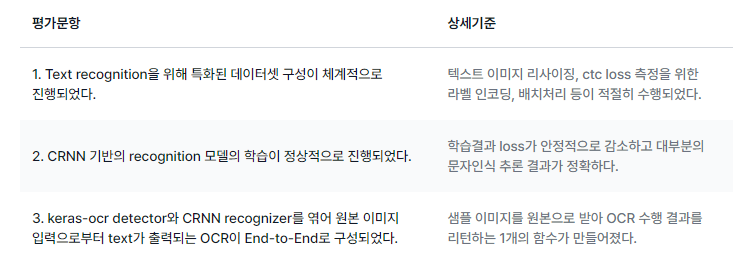

# 환경 세팅

In [70]:
cd /content/drive/MyDrive/대학/활동/아이펠/git/ai/Quests/Quest12_20240708

/content/drive/MyDrive/대학/활동/아이펠/git/ai/Quests/Quest12_20240708


In [71]:
ls

aiffel.ipynb  PRT.md  Quest.ipynb  README.md  sample.jpg


In [28]:
!pip install lmdb

In [29]:
# 필요 패키지
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

In [30]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [31]:
BATCH_SIZE = 128
HOME_DIR = '/content/drive/MyDrive/대학/활동/아이펠/data/data_lmdb_release/training/MJ'

TRAIN_DATA_PATH = HOME_DIR+'/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/MJ_test'

print(TRAIN_DATA_PATH)

/content/drive/MyDrive/대학/활동/아이펠/data/data_lmdb_release/training/MJ/MJ_train


# 데이터셋 구성

* 텍스트 이미지 리사이징
* ctc loss 측정을 위한 라벨 인코딩
* 배치처리

original image width:72, height:31
display img shape:(74, 32, 3)
label:Lube


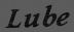

original image width:82, height:31
display img shape:(84, 32, 3)
label:Spencerian


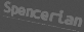

original image width:115, height:31
display img shape:(100, 32, 3)
label:accommodatingly


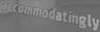

original image width:140, height:31
display img shape:(100, 32, 3)
label:CARPENTER


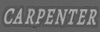

In [32]:
from IPython.display import display # Ipython 환경에서 이미지를 표시하기 위해 필요한 모듈

env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32, # 데이터 베이스 동시 접속 가능한 최대 작업자 수
                readonly=True, # DB 읽기 전용 모드
                lock=False, # DB 잠금 사용 여부
                readahead=False, # 읽기 작업 수행 시 미리 읽기 기능 비활성화
                meminit=False) # DB 초기화시 메모리 할당 여부 설정

with env.begin(write=False) as txn: # 읽기 전용 트랜잭션(txn) 시작
  for index in range(1, 5): # 인덱스 1-4 까지 순회
    label_key = 'label-%09d'.encode() % index # 인덱스에 해당하는 라벨 키 생성 - %09d는 9자리 0으로 채운 정수
    label = txn.get(label_key).decode('utf-8') # DB에서 라벨 키 값을 가져와 UTF-8로 디코딩
    img_key = 'image-%09d'.encode() % index # 인덱스에 해당하는 이미지 키 생성
    imgbuf = txn.get(img_key) # DB에서 이미지 키에 해당하는 값 가져오기 [데이터 형식: Binary]
    buf = six.BytesIO() # 바이너리 데이터를 메모리 버퍼로 처리하기 위해 'BytesIO'객체 생성
    buf.write(imgbuf) # 버퍼에 바이너리 데이터 사용
    buf.seek(0)

    try:
      img = Image.open(buf).convert('RGB') # 버퍼를 열어 RGB 형식으로 변환 시도
    except IOError:
      # 이미지가 손상되었을 경우 라벨을 '-'로 처리
      print('Corrupted image for %s' % img_key)
      label = '-'

    width, height = img.size # 이미지의 원본 너비와 높이 가져오기
    print('original image width:{}, height:{}'.format(width, height))

    target_width = min(int(width*32/height), 100) # 이미지 목표 너비 계산 / 최대 100으로 제한
    target_img_size = (target_width, 32)
    img = np.array(img.resize(target_img_size)).transpose(1,0,2)

    print('display img shape:{}'.format(img.shape))
    print('label:{}'.format(label))
    display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))


데이터를 통해 확인 할 수 있는것은 높이는 32(31)로 고정시키고 너비는 100이하의 다양한 크기로 나온다.
라벨 같은 경우 대소문자가 구분되어 있고 모든 글자들이 일렬로 정렬된 형식이 아닌 약간의 기울기 및 뒤틀림이 존재 하는것을 볼 수 있음

-> 기론 OCR방식이면 Detection & Recognization 방식이지만 해당 데이터셋의 경우 이미 bounding box가 쳐져 있으머로 학습에 넣을 수 있게 전처리 과정(CTC, TPS, ...)을 거치는 방식으로 진행하면 되지 않을까 예상

In [44]:
class MJDatasetSequence(Sequence):
  def __init__(self,
               dataset_path, #lmdb 경로
               label_converter, # 라벨 인코딩/디코딩 도구 - 바로 밑 코드 블럭에서 정의
               batch_size=1, # 배치 크기
               img_size=(100,32),
               max_text_len=22, # 라벨 최대 길이
               is_train=False,
               character='') :
    self.label_converter = label_converter
    self.batch_size = batch_size
    self.img_size = img_size
    self.max_text_len = max_text_len
    self.character = character
    self.is_train = is_train
    self.divide_length = 100

    self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
    with self.env.begin(write=False) as txn:
      self.num_samples = int(txn.get('num-samples'.encode()))
      self.index_list = [index + 1 for index in range(self.num_samples)]

  def __len__(self):
    return math.ceil(self.num_samples / self.batch_size / self.divide_length) # 배치의 총 길이 반환

  # 이미지와 라벨 가져오기 - 위의 코드와 비슷한 방식으로 이미지 & 라벨 가져오는 코드
  def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size

            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)

    # 데이터 가져오기
  def __getitem__(self, idx):
        # 주어진 인덱스에 해당하는 배치 인덱스를 계산
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        # 이미지와 라벨을 저장할 배열을 초기화
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 각 인덱스에 해당하는 이미지와 라벨, 그리고 해당 길이를 준비하여 반환
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        # 입력 및 출력 데이터 준비 및 반환
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        # 어떤 모양의 데이터를 다루는지 알려주는 preset 함수
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

In [45]:
class LabelConverter(object):

  def __init__(self, character):
    # 인코딩할 문자열 앞에 '-'를 추가해 유호한 문자 집합을 확장
    self.character = '-' + character
    self.label_map = dict() # 문자를 인덱스로 매핑하는 딕셔너리
    # 문자 집합의 각 문자에 대해 인덱스를 할당하여 'label_map' 초기화
    for i, char in enumerate(self.character):
      self.label_map[char] = i

  # 텍스트 인코딩
  def encode(self, text):
    encoded_label = [] # 인코딩 된 라벨 저장 리스트
    for i, char in enumerate(text):
      # 연속된 단어가 있을 경우를 고려해 단어를 넣기전 인덱스 0 즉 '-'을 집어넣어 CTC 작업 시행
      if i > 0 and char == text[i - 1]:
        encoded_label.append(0)
      encoded_label.append(self.label_map[char])
    return np.array(encoded_label)

  # 인코딩된 숫자 배열을 다시 텍스트로 디코딩
  def decode(self, encoded_label):
    target_characters = list(self.character) # 문자 집합의 리스트화
    decoded_label = ""
    for encode in encoded_label:
      decoded_label += self.character[encode]
    return decoded_label

In [46]:
label_converter = LabelConverter(TARGET_CHARACTERS)

In [47]:
converter = LabelConverter(TARGET_CHARACTERS)

In [48]:
encoded = converter.encode('HELLO')
print(encoded)

[ 8  5 12  0 12 15]


In [49]:
decoded = converter.decode(encoded)
print(decoded)

HEL-LO


여기서 주의할 요소는 TARGET_CHARACTERS 변수는 모두 대문자 알파벳 및 숫자로 이루어 져 있다는 것

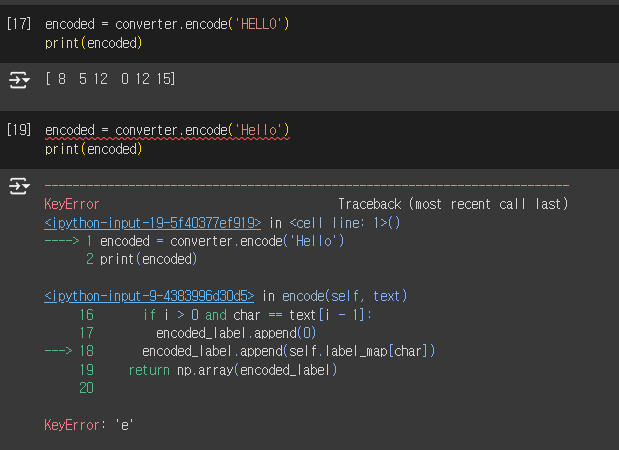

LMDB 데이터셋의 경우 대소문자 혼합으로 구성되어 있기에 이 점을 주의해야 한다

### CTC 손실 함수 역할
1. 불확실성 처리
2. 동적 정렬
3. 연속된 동일 문자 처리

In [50]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    # Keras 백엔드에서 제공하는 CTC 손실 함수, 배치 단위로 CTC 손실율 계산
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

데이터 전처리 함수 및 각종 학습에 필요한 기본 함수들을 저의 하였으니 CRNN 모델 빌드

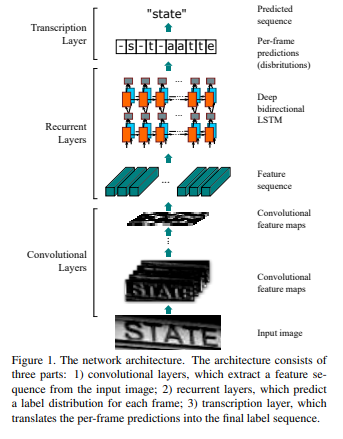

이미지 안에 뭔가가 들어와서 처리가 되는 경우가 있음
-> 높은 확률로 초반 데이터가 잘리는 경우도 있으니 이를 blank 처리를해 모델에 여유를 줘 그런 문제를 해결하는 의도가 아니었을까

In [51]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    # 문자 집합의 크기에 두개의 추가 문자 'blank'와 'CTC'문자를 더한 값
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # 위 이미지 상 첫번째 레이어에 해당 [Convolutional Layers]
    # Build CRNN model
    # Conv2D와 MaxPooling2D레이어를 사용해 특징을 점진적으로 추출하고 크기를 줄임
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    # BatchNormalization 레이어는 각 배치마다 활성화를 정규화하여 훈련을 안정화하고 가속화
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    # 최종적으로 Conv2D 레이어로 특징 맵 생성
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)

    # 2번째 레이어 Recurrent Layer
    # CNN 블록의 출력을 시퀀스 형태로 변환
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    # 변환된 시퀀스에 추가적인 특징 학습
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    # Bidirectional LSTM 레이어는 시퀀스 데이터를 양방향으로 처리해 문맥 정보 추출
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    # 최종 예측을 위한 레이어로 softmax 활성화 함수를 사용해 각 클래스에 대한 확률 분포 출력
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # 3번째 Transcription Layer
    # CTC 손실 계산
    # 실제 라벨을 입력
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    # 입력 시퀀스의 길이 입력
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    # 라벨 시퀀스의 길이 입력
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    # 이전에 생성한 'ctc_lambda_func'함수를 사용해 CTC손실을 계산하는 Lambda 레이어
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )

    # 모델 컴파일
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

이렇게 [An End-to-End Trainable Neural Network for Image-based Sequence
Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717) 논문의 모델 구현

여기서 드는 의문은 outputs으로 결국 CTC Loss값을 얻는 구조로 모델을 빌드하였는데 결과적으로 활용하고 싶은건 이전 덴스 레이어의 각 클래스별 확률 값이 아닌가 함

# 데이터셋 및 모델 준비

In [ ]:
EPOCHS = 30
lr = 0.15

In [58]:
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

In [62]:
model = build_crnn_model()

optimizer = tf.keras.optimizers.Adadelta(lr=lr, clipnorm=5)

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [63]:
# 모델 체크포인트 저장 경로
checkpoint_path = 'model/model_checkpoint.hdf5'
# 모델 체크포인트 콜백 설정
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_bast_only=True,
    mode='min',
    verbose=1
    )
# monitor='val_loss'는 검증 손실을 모니터링
# Patience는 검증 손실이 개선되지 않는 에포크수 5회 이상일 경우 훈련 중지
# restore_best_weights은 가장 낮은 검증 손실을 가진 모델의 가중치 복원
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(train_set,
            steps_per_epoch=len(train_set),
            epochs=EPOCHS,
            validation_data=val_set,
            validation_steps=len(val_set),
            callbacks=[ckp, earlystop]
)

Epoch 1/30
565/565 [==============================] - ETA: 0s - loss: 33.9614
Epoch 1: saving model to model/model_checkpoint.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


565/565 [==============================] - 50s 73ms/step - loss: 33.9614 - val_loss: 27.4582
Epoch 2/30
565/565 [==============================] - ETA: 0s - loss: 26.8750
Epoch 2: saving model to model/model_checkpoint.hdf5
565/565 [==============================] - 40s 70ms/step - loss: 26.8750 - val_loss: 26.7285
Epoch 3/30
565/565 [==============================] - ETA: 0s - loss: 26.4239
Epoch 3: saving model to model/model_checkpoint.hdf5
565/565 [==============================] - 39s 69ms/step - loss: 26.4239 - val_loss: 26.4305
Epoch 4/30
565/565 [==============================] - ETA: 0s - loss: 26.1959
Epoch 4: saving model to model/model_checkpoint.hdf5
565/565 [==============================] - 40s 70ms/step - loss: 26.1959 - val_loss: 26.2722
Epoch 5/30
565/565 [==============================] - ETA: 0s - loss: 26.0396
Epoch 5: saving model to model/model_checkpoint.hdf5
565/565 [==============================] - 39s 69ms/step - loss: 26.0396 - val_loss: 26.1212
Epoch 6/30


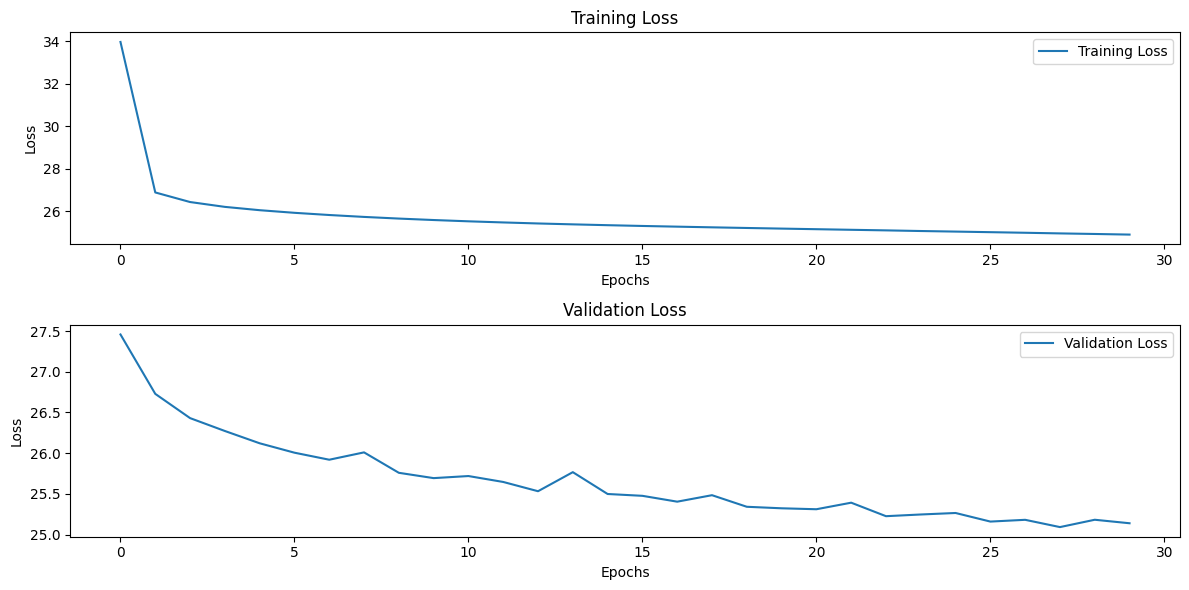

In [69]:
import matplotlib.pyplot as plt

# 학습 및 검증 손실 시각화
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Training loss
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Validation loss
    plt.subplot(2,1,2)
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

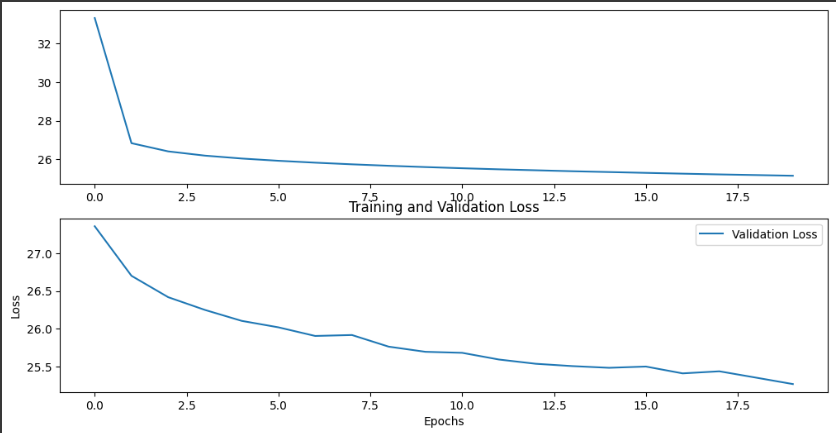

### Epoch 30 - LR 0.15

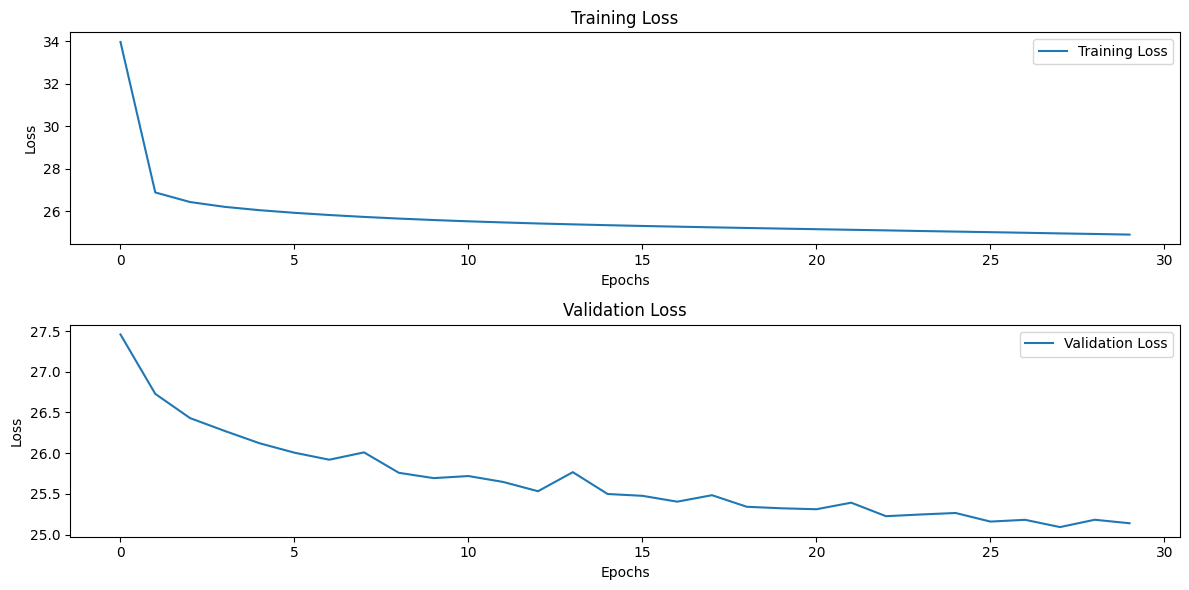

20 에폭으로 진행하였는데 아직 오버피팅 현상이 발생하지 않아 보여 에폭수를 늘리고 학습률도 늘려 다시 실험

epoch 20 -> 30
lr 0.1 -> 0.15

이전에 가졌던 의문인 y_pred 사용여부를 해결한 코드
체크포인트로부터 weight를 가져와 output을 변경시켜 목적에 맞게 모델 변형

In [55]:
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

1/1 [==============================] - 2s 2s/step
Result: 	 IES999999999999999999999


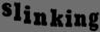

1/1 [==============================] - 0s 23ms/step
Result: 	 ES9999999999999999999999


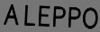

1/1 [==============================] - 0s 23ms/step
Result: 	 IES999999999999999999999


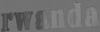

1/1 [==============================] - 0s 23ms/step
Result: 	 IES999999999999999999999


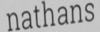

1/1 [==============================] - 0s 23ms/step
Result: 	 S99999999999999999999999


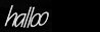

1/1 [==============================] - 0s 24ms/step
Result: 	 E99999999999999999999999


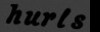

1/1 [==============================] - 0s 24ms/step
Result: 	 IES999999999999999999999


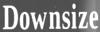

1/1 [==============================] - 0s 23ms/step
Result: 	 ES9999999999999999999999


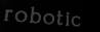

1/1 [==============================] - 0s 23ms/step
Result: 	 S99999999999999999999999


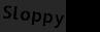

1/1 [==============================] - 0s 23ms/step
Result: 	 IES999999999999999999999


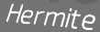

In [56]:
from IPython.display import display

# 모델이 Inference한 결과를 글자로 바꿔주는 역할
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# END to END OCR

In [73]:
!pip install keras_ocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 9.1 MB/s eta 0:00:00


In [75]:
ls

aiffel.ipynb  PRT.md  Quest.ipynb  README.md  sample.jpg


In [76]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = 'sample.jpg'

detector = Detector()

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [77]:
import keras_ocr
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

def detect_text(img_path):

    # 이미지를 불러옵니다
    img_pil = Image.open(img_path).convert('RGB')
    img = np.array(img_pil)

    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    img = np.expand_dims(img, axis=0)

    # 텍스트를 감지합니다
    ocr_result = detector.detect(img)

    # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = ocr_result[0]

    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    result_img = img_pil.copy()
    img_draw = ImageDraw.Draw(result_img)

    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

1/1 [==============================] - 3s 3s/step


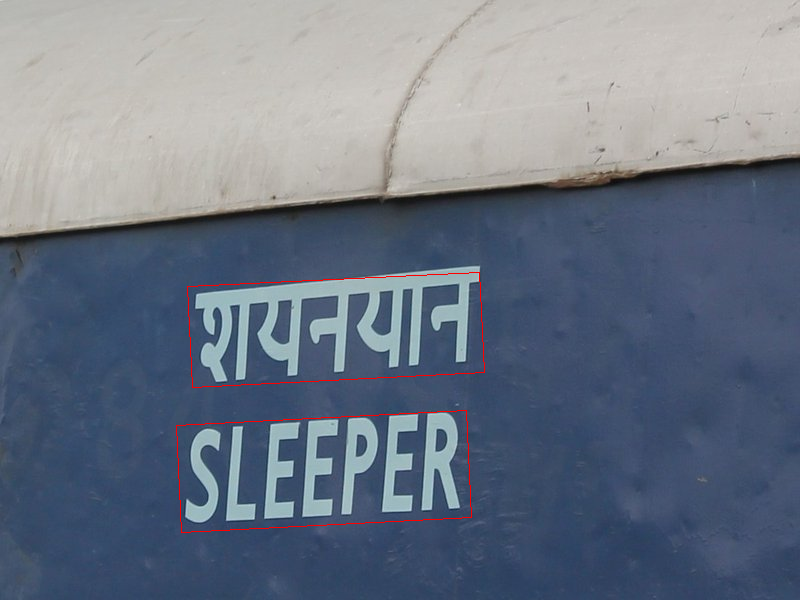

In [78]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

# 회고

배운점:
다양한 방법의 문자 인식 기법들을 배웠습니다

느낀점:
단순 OCR 모델임에도 안의 구성요소들이 정말 다양하다는것을 느꼈습니다.

아쉬운점:
케라스 모델을 불러와 하는 것이 아닌 직접 튜닝을 진행해봤으면 더 좋았을것 같습니다.

궁금한 내용:
위 ipynb에서 언급되었듯이 각 모델 세부 내용들이 궁금했었는데 다시 구성하면서 더 생각할 거리가 많았던거 같습니다.

SyntaxError: invalid syntax (<ipython-input-79-e429b5ae742e>, line 1)